![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

# Destination Earth - OLCI Level 1B Reduced Resolution - Sentinel-3 - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[OLCI Level 1B Reduced Resolution - Sentinel-3](https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:OL_1_ERR___NRT)

## Authenticate on DESP

In [37]:
import destinelab as deauth

In [38]:
import requests
import json
import os
from getpass import getpass

In [39]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Search data

Now, we search a product matching our filters.

For this example, we search data for the [OLCI Level 1B Reduced Resolution - Sentinel-3](https://hda.data.destination-earth.eu/ui/dataset/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___) dataset. 

The corresponding collection ID in HDA for this dataset is: EO.EUM.DAT.SENTINEL-3.OL_1_ERR___.

In [54]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.EUM.DAT.SENTINEL-3.OL_1_ERR___"],
    "datetime": "2024-06-25T00:00:00Z/2024-06-30T00:00:00Z",
    "bbox":  [10,53,30,66],
})


We can have a look at the metadata of the first products returned by the search.

In [55]:
from IPython.display import JSON

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

### Download one product



In [56]:
from tqdm import tqdm
import time

assets = ["downloadLink"]

for asset in assets:
    download_url = product["assets"][asset]["href"]
    print(download_url)
    filename = product["id"]
    print(filename)
    response = requests.get(download_url, headers=auth_headers)
    total_size = int(response.headers.get("content-length", 0))

    print(f"downloading {filename}")

    with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
        with open(filename, 'wb') as f:
            for data in response.iter_content(1024):
                progress_bar.update(len(data))
                f.write(data)

https://hda.data.destination-earth.eu/stac/collections/EO.EUM.DAT.SENTINEL-3.OL_1_ERR___/items/S3B_OL_1_ERR____20240625T083313_20240625T091737_20240625T110705_2664_094_278______PS2_O_NR_004/download?provider=dedl
S3B_OL_1_ERR____20240625T083313_20240625T091737_20240625T110705_2664_094_278______PS2_O_NR_004
downloading S3B_OL_1_ERR____20240625T083313_20240625T091737_20240625T110705_2664_094_278______PS2_O_NR_004


925MB [00:01, 616MB/s] 


#### unzip

In [57]:
import os
import zipfile

zf=zipfile.ZipFile(filename)
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('.')

### Satpy


In [58]:
pip install --quiet satpy pyspectral

Note: you may need to restart the kernel to use updated packages.


In [59]:
from satpy.scene import Scene
from satpy.composites import GenericCompositor
from satpy.writers import to_image
from satpy.resample import get_area_def
from satpy import available_readers
from satpy import MultiScene

import pyresample
import pyspectral

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [60]:
from datetime import datetime
from satpy import Scene, find_files_and_readers

files = find_files_and_readers(sensor='olci',
                               start_time=datetime(2024, 6, 25, 0, 0),
                               end_time=datetime(2024, 6, 30, 0, 0),
                               base_dir=".",
                               reader='olci_l1b')

scn = Scene(filenames=files)
# print available datasets
scn.available_dataset_names()

['Oa01',
 'Oa02',
 'Oa03',
 'Oa04',
 'Oa05',
 'Oa06',
 'Oa07',
 'Oa08',
 'Oa09',
 'Oa10',
 'Oa11',
 'Oa12',
 'Oa13',
 'Oa14',
 'Oa15',
 'Oa16',
 'Oa17',
 'Oa18',
 'Oa19',
 'Oa20',
 'Oa21',
 'altitude',
 'humidity',
 'latitude',
 'longitude',
 'mask',
 'quality_flags',
 'satellite_azimuth_angle',
 'satellite_zenith_angle',
 'sea_level_pressure',
 'solar_azimuth_angle',
 'solar_zenith_angle',
 'total_columnar_water_vapour',
 'total_ozone']

In [61]:
scn.available_composite_ids()

[DataID(name='day_essl_colorized_low_level_moisture'),
 DataID(name='day_essl_low_level_moisture'),
 DataID(name='essl_colorized_low_level_moisture'),
 DataID(name='essl_low_level_moisture'),
 DataID(name='ocean_color'),
 DataID(name='true_color'),
 DataID(name='true_color_desert'),
 DataID(name='true_color_land'),
 DataID(name='true_color_marine_clean'),
 DataID(name='true_color_marine_tropical'),
 DataID(name='true_color_raw')]

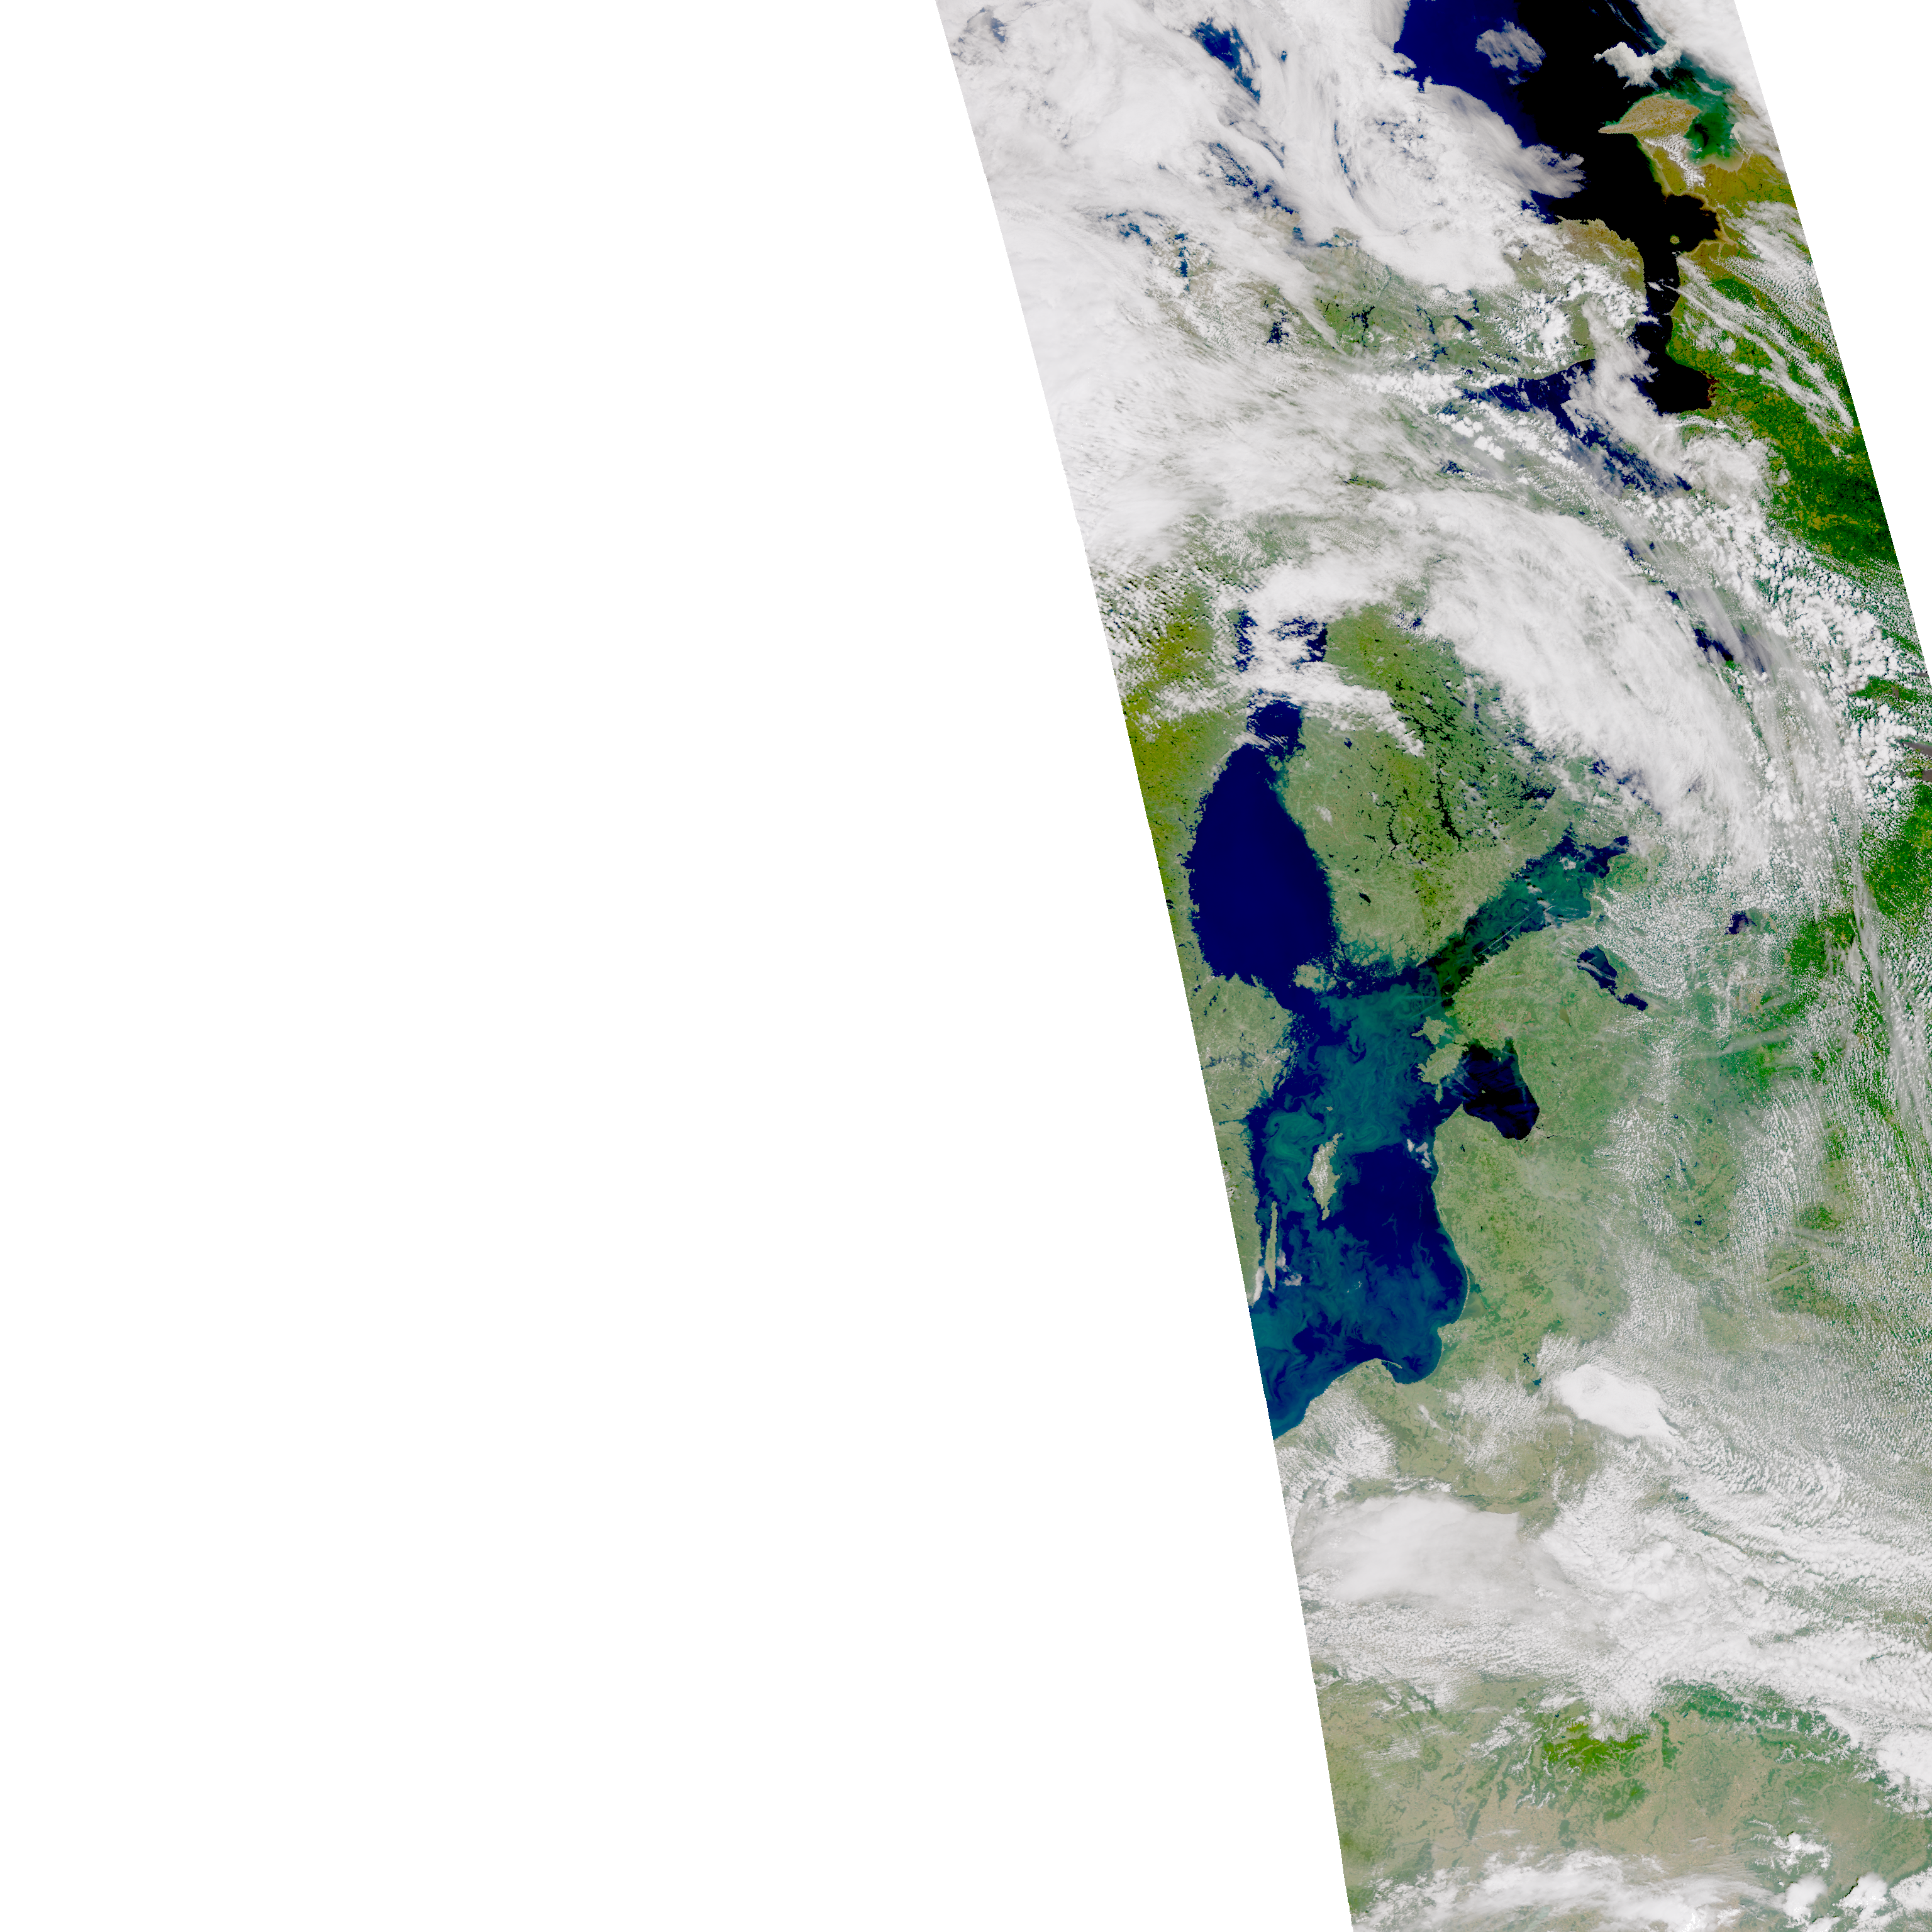

In [64]:
composite = "ocean_color"

scn.load([composite])

newscn = scn.resample("euron1")
newscn.load([composite])
newscn.show(composite)